### Imports

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import CoolProp.CoolProp as CP
import src.Fluid_CP as FCP
import src.Compressormodel_SP as CSP
from scipy.integrate import odeint
import numpy as np
from scipy.optimize import minimize, NonlinearConstraint


### Parameters and Variables

In [53]:
# Constants and parameters (as you have)
tc_s = 7*60          # total cooking time seconds
tb_s = 0         # pasta added after 5 min
R_env = 30 / 1000    # K/W
R_pasta = 15 / 1000  # K/W
c_l = 4.18 * 1000    # J/kg·K water
c_pasta = 3.5 * 1000 # J/kg·K pasta

V_water = (47-0.4)*(27-0.4)*(20-0.2)/1e6  # m3
m_water = V_water * 1000                   # kg
m_pasta = 2                              # kg

T_env = 20
T_water_0 = 85
T_pasta_0 = 7

dt = 1  # 1 second timestep
time_steps = int(tc_s/dt) + 1
t = np.linspace(0, tc_s, time_steps)

### Differential Equations for "only-water" and "with-pasta" case

In [54]:
def simulate_temps(Q, t_on, t_off):
    T_water = np.zeros(time_steps)
    T_pasta = np.zeros(time_steps)
    T_water[0] = T_water_0
    T_pasta[0] = T_pasta_0
    C_water = m_water * c_l
    C_pasta = m_pasta * c_pasta

    for i in range(1, time_steps):
        Q_applied = Q if t_on <= t[i] <= t_off else 0

        dT_water = dt * (Q_applied - (T_water[i - 1] - T_env) / R_env - (T_water[i - 1] - T_pasta[i - 1]) / R_pasta) / C_water
        dT_pasta = dt * ((T_water[i - 1] - T_pasta[i - 1]) / R_pasta) / C_pasta
        T_water[i] = T_water[i - 1] + dT_water
        T_pasta[i] = T_pasta[i - 1] + dT_pasta

    return T_water, T_pasta


### Objective: total energy = Q⋅(t_off−t_on):

In [55]:
def objective(x):
    Q, t_on, t_off = x
    energy_kJ = Q * (t_off - t_on) / 1000
    return energy_kJ


### Constraints:

In [65]:
def water_temp_constraint(x):
    Q, t_on, t_off = x
    T_water, _ = simulate_temps(Q, t_on, t_off)
    idx_start = int(tb_s / dt)
    min_lower = np.min(T_water[idx_start:] - 85)
    min_upper = np.min(93 - T_water[idx_start:])
    return [min_lower, min_upper]

def pasta_temp_constraint(x):
    Q, t_on, t_off = x
    _, T_pasta = simulate_temps(Q, t_on, t_off)
    return T_pasta[-1] - 85


###  Optimization setup:

Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: 1427.199421924491
            Iterations: 332
            Function evaluations: 3626
            Gradient evaluations: 328
Optimization success: False
Optimal Q: 6961.95 W
Heat pump ON: 0.13 min
Heat pump OFF: 3.55 min


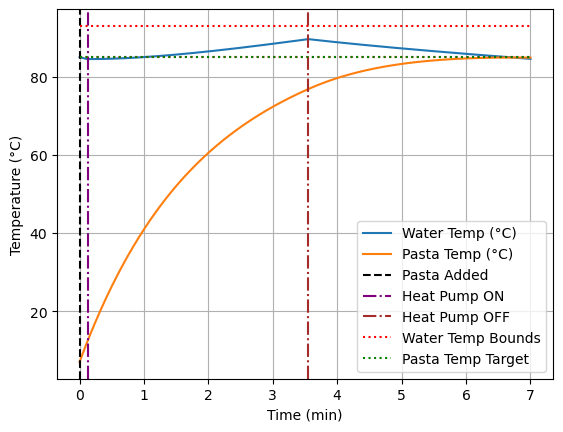

In [67]:
from scipy.optimize import Bounds

NC_water = NonlinearConstraint(water_temp_constraint, [0, 0], [np.inf, np.inf])
NC_pasta = NonlinearConstraint(pasta_temp_constraint, 0, np.inf)
constraints = [NC_water, NC_pasta]

# Bounds: Q in [0, 5000], t_on in [0, tc_s], t_off in [0, tc_s]
bounds = Bounds([0, 0, 0], [10000, tc_s, tc_s])


x0 = [3000, 0, 600]  # initial guess: Q=3000, on at 0 min, off at 10 min

result = minimize(
    objective,
    x0,
    method='SLSQP',
    bounds=bounds,
    constraints=constraints,
    options={
        'ftol': 1e-4,         # objective tolerance (default is 1e-6)
        'maxiter': 1000,       # allow more iterations
        'disp': True          # print debug info
    }
)


Q_opt, t_on_opt, t_off_opt = result.x
print("Optimization success:", result.success)
print(f"Optimal Q: {Q_opt:.2f} W")
print(f"Heat pump ON: {t_on_opt/60:.2f} min")
print(f"Heat pump OFF: {t_off_opt/60:.2f} min")

# Final simulation
T_water_final, T_pasta_final = simulate_temps(Q_opt, t_on_opt, t_off_opt)


plt.plot(t/60, T_water_final, label='Water Temp (°C)')
plt.plot(t/60, T_pasta_final, label='Pasta Temp (°C)')
plt.axvline(x=0, color='k', linestyle='--', label='Pasta Added')
plt.axvline(x=t_on_opt/60, color='purple', linestyle='-.', label='Heat Pump ON')
plt.axvline(x=t_off_opt/60, color='brown', linestyle='-.', label='Heat Pump OFF')
plt.hlines([85, 93], 0, 7, colors='r', linestyles='dotted', label='Water Temp Bounds')
plt.hlines(85, 0, 7, colors='g', linestyles='dotted', label='Pasta Temp Target')
plt.xlabel('Time (min)')
plt.ylabel('Temperature (°C)')
plt.legend()
plt.grid()
plt.show()


### Export